# **Import Library**

In [37]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import plotly.express as px

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.24.3
pandas version :  2.2.0
seaborn version :  0.12.2


In [38]:
# Mengubah parameter default matplotlib

from matplotlib import rcParams

rcParams['figure.figsize'] = 12, 4
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'

# **Import Dataset**

In [39]:
# load data
df = pd.read_csv('Train.csv')

# Rename kolom 
df = df.rename(columns={'Warehouse_block':'Warehouse',
                        'Mode_of_Shipment':'Shipment',
                        'Customer_care_calls':'Calls',
                        'Customer_rating':'Rating',
                        'Cost_of_the_Product':'Cost',
                        'Prior_purchases':'Purchases',
                        'Product_importance':'Importance',
                        'Discount_offered':'Discount',
                        'Weight_in_gms':'Weight (gram)',
                        'Reached.on.Time_Y.N':'Late'})

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             10999 non-null  int64 
 1   Warehouse      10999 non-null  object
 2   Shipment       10999 non-null  object
 3   Calls          10999 non-null  int64 
 4   Rating         10999 non-null  int64 
 5   Cost           10999 non-null  int64 
 6   Purchases      10999 non-null  int64 
 7   Importance     10999 non-null  object
 8   Gender         10999 non-null  object
 9   Discount       10999 non-null  int64 
 10  Weight (gram)  10999 non-null  int64 
 11  Late           10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [41]:
#pengelompokkan jenis feature
cat = ['Warehouse', 'Shipment', 'Importance', 'Gender'] 
num = ['Calls', 'Rating', 'Cost', 'Purchases', 'Discount', 'Weight (gram)', 'Late'] 

In [42]:
df.sample(5)

,ID,Warehouse,Shipment,Calls,Rating,Cost,Purchases,Importance,Gender,Discount,Weight (gram),Late
5662,5663,C,Ship,4,2,237,3,low,M,2,5277,0
8570,8571,A,Ship,3,1,165,3,low,M,10,5823,0
5445,5446,B,Ship,3,5,252,4,low,F,7,5328,1
5023,5024,F,Ship,6,5,274,4,low,M,6,1066,0
10695,10696,B,Flight,3,5,222,3,low,F,10,5185,1


In [43]:
# Summary feature numerical
df[num].describe()

,Calls,Rating,Cost,Purchases,Discount,Weight (gram),Late
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


Beberapa pengamatan:

1. Kolom `Calls`, `Rating`, `Cost`, dan `Weight (gram)` tampak sudah cukup simetrik distribusinya (mean dan median tak berbeda jauh)
2. Kolom `Purchase` dan `Discount` tampaknya skew ke kanan (long-right tail), mungkin dapat dilakukan transformasi log nantinya
3. Kolom `Late` atau target bernilai boolean/binary

In [11]:
# Summary feature categorical
df[cat].describe()

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
count,10999,10999,10999,10999
unique,5,3,3,2
top,F,Ship,low,F
freq,3666,7462,5297,5545


# **Stage 2**

## **1. Data Cleansing**


### A. Handle Missing Value and Duplicate Data

In [12]:
df.isna().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

**Pengamatan: Tidak ada missing value pada data**

### B. Handle Duplicated Data

In [45]:
# cek baris yang duplikat
print(f'Jumlah row duplicated = {df.duplicated().sum()}')

Jumlah row duplicated = 0


**Tidak ada data duplikat pada dataset**

### C. Handle Outliers

In [33]:
import pandas as pd

def outliers(df):
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    outliers_count = {}
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_indices = (df[col] < lower_bound) | (df[col] > upper_bound)
        outliers_count[col] = sum(outlier_indices)
        
        count = len(df[col])
        print(f"Column '{col}':")
        print(f"  Total values: {count}")
        print(f"  Outliers: {outliers_count[col]}")
        
    return outliers_count

In [34]:
# Memanggil fungsi outliers
# outliers_count = outliers(DL)
outliers_count = outliers(df)

Column 'ID':
  Total values: 10999
  Outliers: 0
Column 'Customer_care_calls':
  Total values: 10999
  Outliers: 0
Column 'Customer_rating':
  Total values: 10999
  Outliers: 0
Column 'Cost_of_the_Product':
  Total values: 10999
  Outliers: 0
Column 'Prior_purchases':
  Total values: 10999
  Outliers: 1003
Column 'Product_importance':
  Total values: 10999
  Outliers: 0
Column 'Gender':
  Total values: 10999
  Outliers: 0
Column 'Discount_offered':
  Total values: 10999
  Outliers: 2209
Column 'Weight_in_gms':
  Total values: 10999
  Outliers: 0
Column 'Reached.on.Time_Y.N':
  Total values: 10999
  Outliers: 0


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

def outliers_visual(df):
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    plt.figure(figsize=(20, 15))
    for i in range(0, len(num_cols)):
        plt.subplot(3, 4, i+1)
        sns.boxplot(x=df[num_cols[i]])

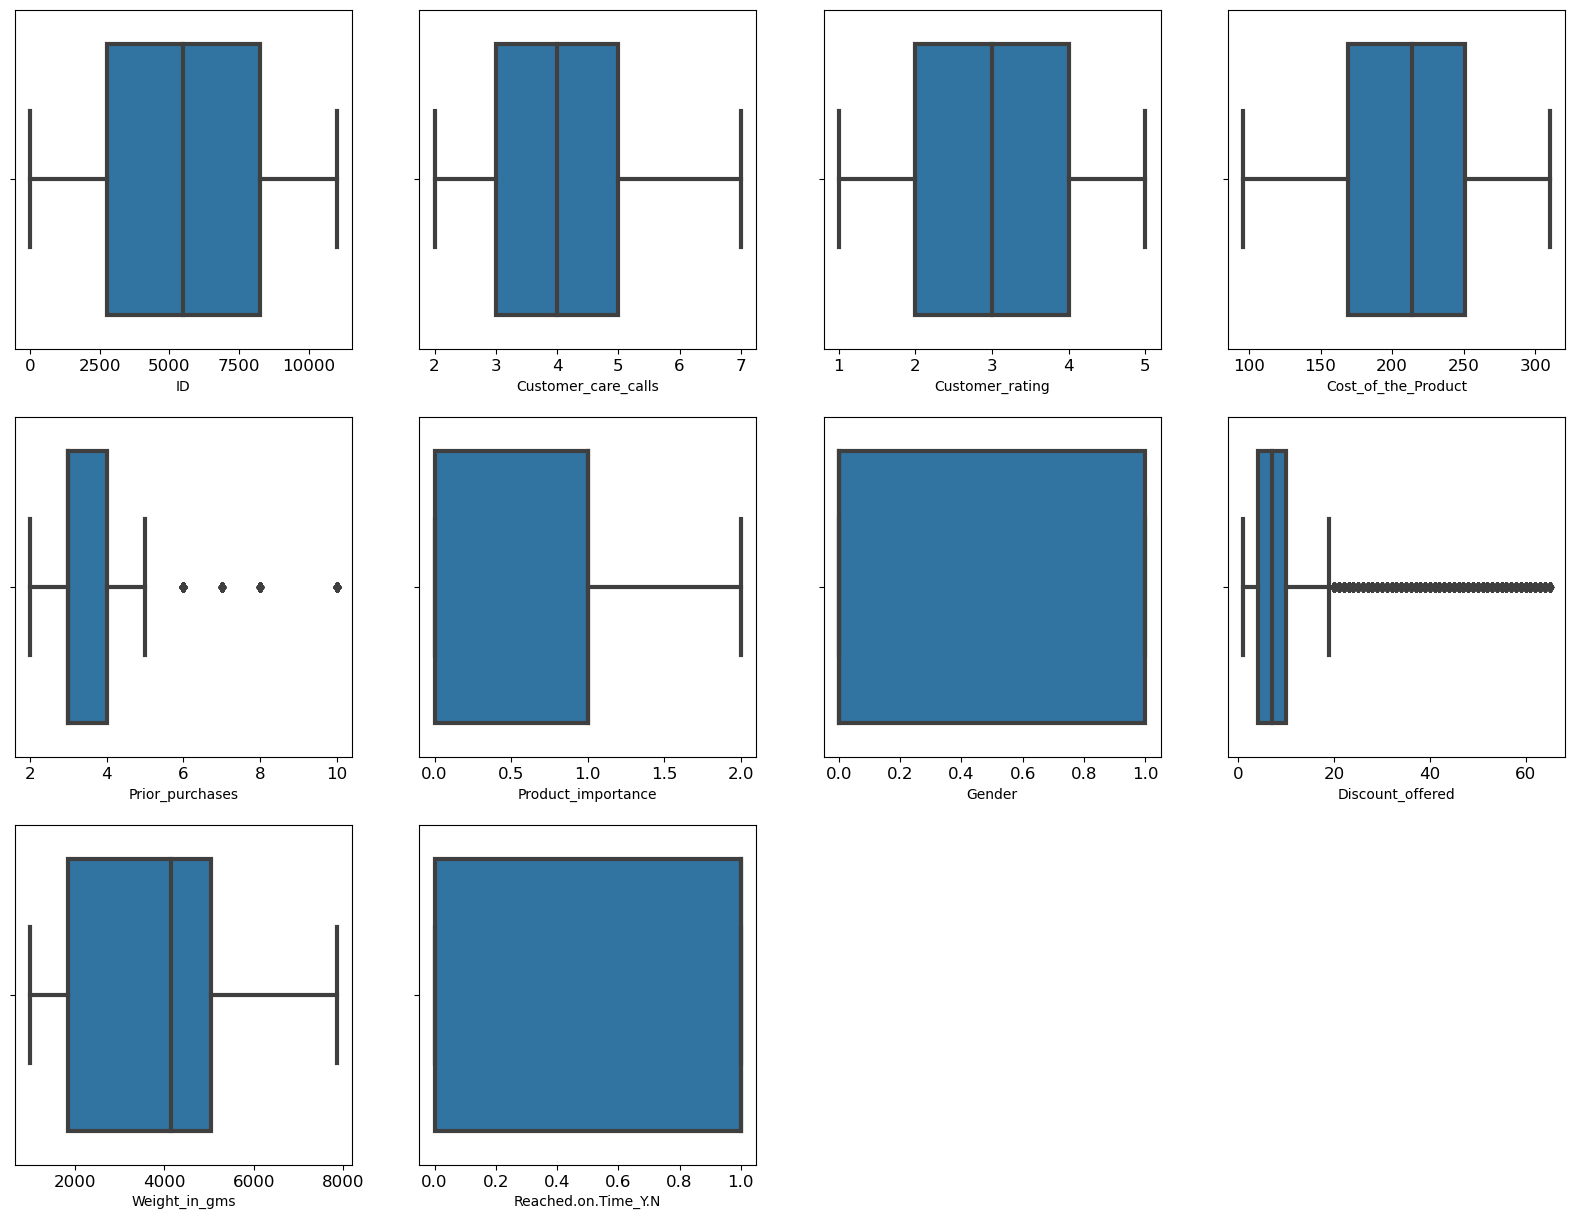

In [36]:
outliers_visual(df)

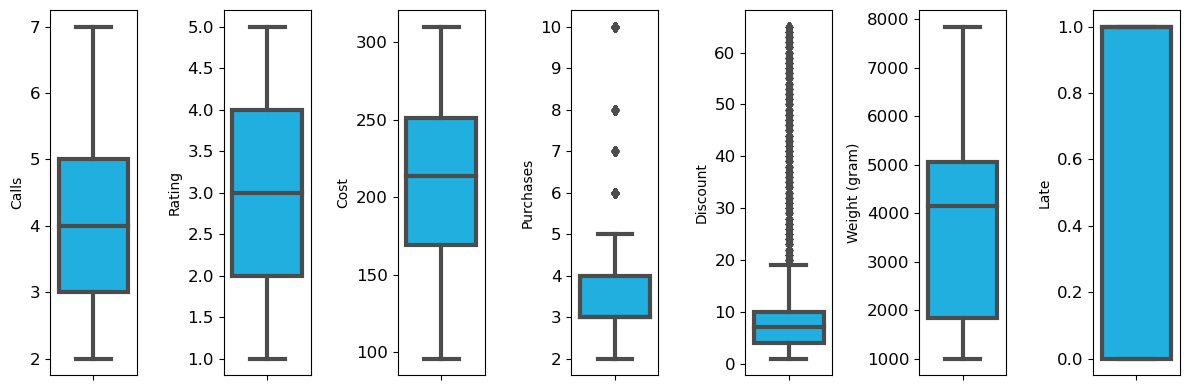

In [47]:
# cek boxplot kolom tipe data int/float uuntuk melihat outlier

for i in range(0, len(num)):
    plt.subplot(1, len(num), i+1)
    sns.boxplot(y=df[num[i]], color='deepskyblue', orient='v')
    plt.tight_layout()

Kita akan menggunakan Z-score filtering (cenderung lebih konservatif)

In [49]:
from scipy import stats

# Remove outlier Z-Score
print(f'Jumlah baris sebelum memfilter outlier: {len(df)}')

filtered_entries = np.array([True] * len(df))

for col in num:
    zscore = abs(stats.zscore(df[col])) # hitung absolute z-scorenya
    filtered_entries = (zscore < 3) & filtered_entries # keep yang kurang dari 3 absolute z-scorenya
    
df = df[filtered_entries] # filter, cuma ambil yang z-scorenya dibawah 3

print(f'Jumlah baris setelah memfilter outlier: {len(df)}')

Jumlah baris sebelum memfilter outlier: 10999
Jumlah baris setelah memfilter outlier: 10642


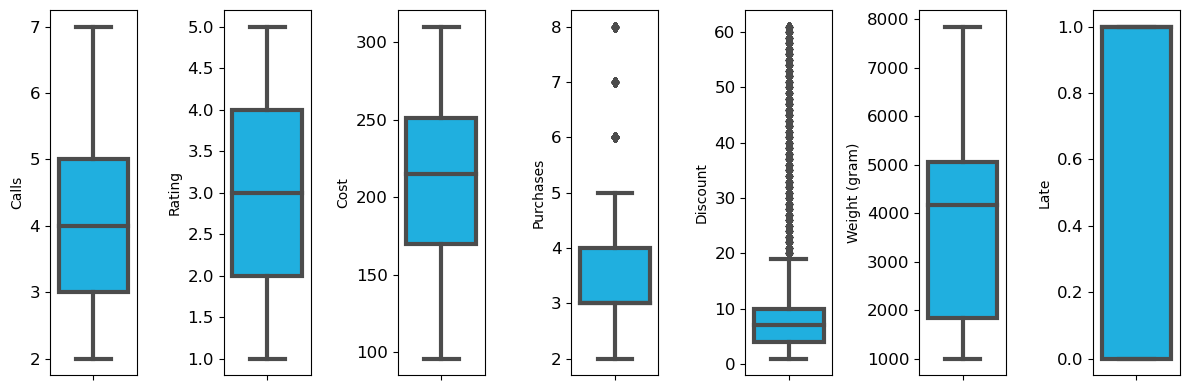

In [50]:
for i in range(0, len(num)):
    plt.subplot(1, len(num), i+1)
    sns.boxplot(y=df[num[i]], color='deepskyblue', orient='v')
    plt.tight_layout()

**Pengamatan: Outliers pada feature `Purchase` dan `Discount` cukup berkurang**

### D. Feature Transformation


__*Log Tranformation*__

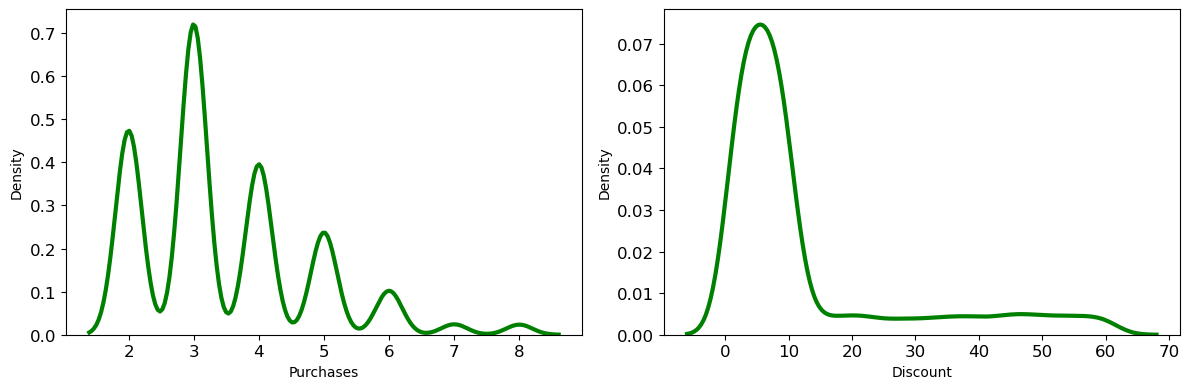

In [51]:
# cek distribusi kolom Purchase dan Discount

log_trans = ['Purchases', 'Discount']

for i in range(0, len(log_trans)):
    plt.subplot(1, len(log_trans), i+1)
    sns.kdeplot(x=df[log_trans[i]], color='green')
    plt.tight_layout()

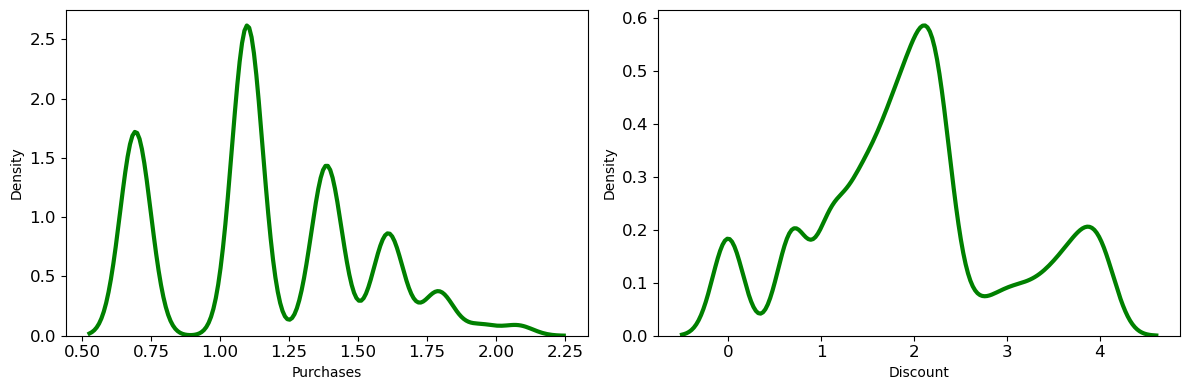

In [52]:
# distribusi purchases dan discount (setelah log transformation)
for i in range(0, len(log_trans)):
    plt.subplot(1, len(log_trans), i+1)
    sns.kdeplot(np.log(df[log_trans[i]]), color='green')
    plt.tight_layout()
    
# lebih mendekati distribusi normal!

In [53]:
# cek nilai skewness feature 

print('skewness feature diskon sebelum log transform: ', df['Discount'].skew(axis=0, skipna=True))
print('skewness feature diskon setelah log transform:', np.log(df['Discount']).skew(axis=0, skipna=True))

print('skewness feature purchases sebelum log transform: ', df['Purchases'].skew(axis=0, skipna=True))
print('skewness feature purchases setelah log transform:', np.log(df['Purchases']).skew(axis=0, skipna=True))

skewness feature diskon sebelum log transform:  1.861919412884021
skewness feature diskon setelah log transform: 0.20425712287711678
skewness feature purchases sebelum log transform:  1.0124137039294367
skewness feature purchases setelah log transform: 0.22520898855880445


In [64]:
#kita transfprmasi
df['log_purchases'] = np.log(df['Purchases'])
df['log_discount'] = np.log(df['Discount'])

# drop kolom purchases dan discount (nilai asli)
df = df.drop(columns=['Purchases', 'Discount'])

KeyError: 'Purchases'

__*Normalization/Standardization*__

In [57]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Normalisasi :
df['norm_rating'] = MinMaxScaler().fit_transform(df['Rating'].values.reshape(len(df), 1))

#Standarisasi :
df['std_calls'] = StandardScaler().fit_transform(df['Calls'].values.reshape(len(df), 1))
df['std_cost'] = StandardScaler().fit_transform(df['Cost'].values.reshape(len(df), 1))
df['std_purchases'] = StandardScaler().fit_transform(df['log_purchases'].values.reshape(len(df), 1))
df['std_discount'] = StandardScaler().fit_transform(df['log_discount'].values.reshape(len(df), 1))
df['std_weight (gram)'] = StandardScaler().fit_transform(df['Weight (gram)'].values.reshape(len(df), 1))

In [58]:
df.describe()

,ID,Calls,Rating,Cost,Weight (gram),Late,log_purchases,log_discount,norm_rating,std_calls,std_cost,std_purchases,std_discount,std_weight (gram)
count,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000,1.064200e+04,1.064200e+04,1.064200e+04,1.064200e+04,1.064200e+04
mean,5570.347773,4.065683,2.989194,210.578557,3646.514189,0.590303,1.178075,1.961307,0.497298,2.777540e-16,-5.341423e-17,3.204854e-16,3.204854e-16,6.409707e-17
std,3159.806013,1.145348,1.412344,48.077818,1639.849048,0.491801,0.354866,1.055971,0.353086,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00
min,1.000000,2.000000,1.000000,96.000000,1001.000000,0.000000,0.693147,0.000000,0.000000,-1.803627e+00,-2.383302e+00,-1.366573e+00,-1.857436e+00,-1.613343e+00
25%,2881.250000,3.000000,2.000000,170.000000,1837.000000,0.000000,1.098612,1.386294,0.250000,-9.304889e-01,-8.440579e-01,-2.239342e-01,-5.445597e-01,-1.103516e+00
50%,5604.500000,4.000000,3.000000,215.000000,4172.000000,1.000000,1.098612,1.945910,0.500000,-5.735048e-02,9.196863e-02,-2.239342e-01,-1.458112e-02,3.204627e-01
75%,8300.750000,5.000000,4.000000,251.000000,5063.750000,1.000000,1.386294,2.302585,0.750000,8.157880e-01,8.407899e-01,5.867809e-01,3.232043e-01,8.642883e-01
max,10999.000000,7.000000,5.000000,310.000000,7846.000000,1.000000,2.079442,4.110874,1.000000,2.562065e+00,2.068025e+00,2.540135e+00,2.035726e+00,2.561018e+00


**Yang dilakukan: Beberapa fitur distandarisasi untuk memudahkan pemodelan dan juga membuat fitur mendekati distribusi normal. khusus `rating` dinormalisasi karena kita sudah mengetahui batas ratingnya yaitu 1-5 jadi hanya perlu dinormalisasi.**

### E. Feature Encoding

In [59]:
#melihat feature kategorikal
for col in cat:
  print(f'value counts of column {col}')
  print(df[col].value_counts())
  print('---'*10, '\n')

value counts of column Warehouse
Warehouse
F    3539
B    1778
D    1777
A    1777
C    1771
Name: count, dtype: int64
------------------------------ 

value counts of column Shipment
Shipment
Ship      7211
Flight    1728
Road      1703
Name: count, dtype: int64
------------------------------ 

value counts of column Importance
Importance
low       5173
medium    4587
high       882
Name: count, dtype: int64
------------------------------ 

value counts of column Gender
Gender
F    5356
M    5286
Name: count, dtype: int64
------------------------------ 



Strategi encoding<br>
- `gender` & `importance` : label encoding (kategori ordinal)
- `shipment` & `warehouse` : One Hot Encoding (kategori bukan ordinal)

In [60]:
#gender dan importance (label encoding)
mapping_Gender = {
    'F' : 0,
    'M' : 1
}

mapping_Importance = {
    'low' : 0,
    'medium' : 1,
    'high' : 2,
}

# replace kolom gender yang telah dikuantifikasi di dataset
df['Gender'] = df['Gender'].map(mapping_Gender)
df['Importance'] = df['Importance'].map(mapping_Importance)

In [61]:
#shipment dan warehouse (one hot encoding)
for cat in ['Warehouse', 'Shipment']:
    onehots = pd.get_dummies(df[cat], prefix=cat)
    df = df.join(onehots)

In [62]:
df.head()

,ID,Warehouse,Shipment,Calls,Rating,Cost,Importance,Gender,Weight (gram),Late,...,std_discount,std_weight (gram),Warehouse_A,Warehouse_B,Warehouse_C,Warehouse_D,Warehouse_F,Shipment_Flight,Shipment_Road,Shipment_Ship
0,1,D,Flight,4,2,177,0,0,1233,1,...,1.726343,-1.471860,False,False,False,True,False,True,False,False
1,2,F,Flight,4,5,216,0,1,3088,1,...,2.004155,-0.340605,False,False,False,False,True,True,False,False
2,3,A,Flight,2,2,183,0,1,3374,1,...,1.808746,-0.166190,True,False,False,False,False,True,False,False
3,4,B,Flight,3,3,176,1,1,1177,1,...,0.323204,-1.506011,False,True,False,False,False,True,False,False
4,5,C,Flight,2,2,184,1,0,2484,1,...,1.768441,-0.708949,False,False,True,False,False,True,False,False


### F. Handle Class Imbalance

In [63]:
#cek ratio jumlah nilai target

df_late = df.groupby('Late').agg({'ID':'count'}).reset_index().rename(columns={'ID':'Jumlah'})
df_late['Ratio'] = df_late['Jumlah']*100/df_late['Jumlah'].sum()
df_late

,Late,Jumlah,Ratio
0,0,4360,40.969743
1,1,6282,59.030257


Tidak perlu dilakukan karena proportion of minority class > 40%

## **2. Feature Engineering**

### **A. Feature Selection**

In [65]:
#melihat kolom int/float/bool

num_dtypes = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'bool']

num_df = df.select_dtypes(include = num_dtypes)
numericals = num_df.columns

print(numericals)

Index(['ID', 'Calls', 'Rating', 'Cost', 'Importance', 'Gender',
       'Weight (gram)', 'Late', 'log_purchases', 'log_discount', 'norm_rating',
       'std_calls', 'std_cost', 'std_purchases', 'std_discount',
       'std_weight (gram)', 'Warehouse_A', 'Warehouse_B', 'Warehouse_C',
       'Warehouse_D', 'Warehouse_F', 'Shipment_Flight', 'Shipment_Road',
       'Shipment_Ship'],
      dtype='object')


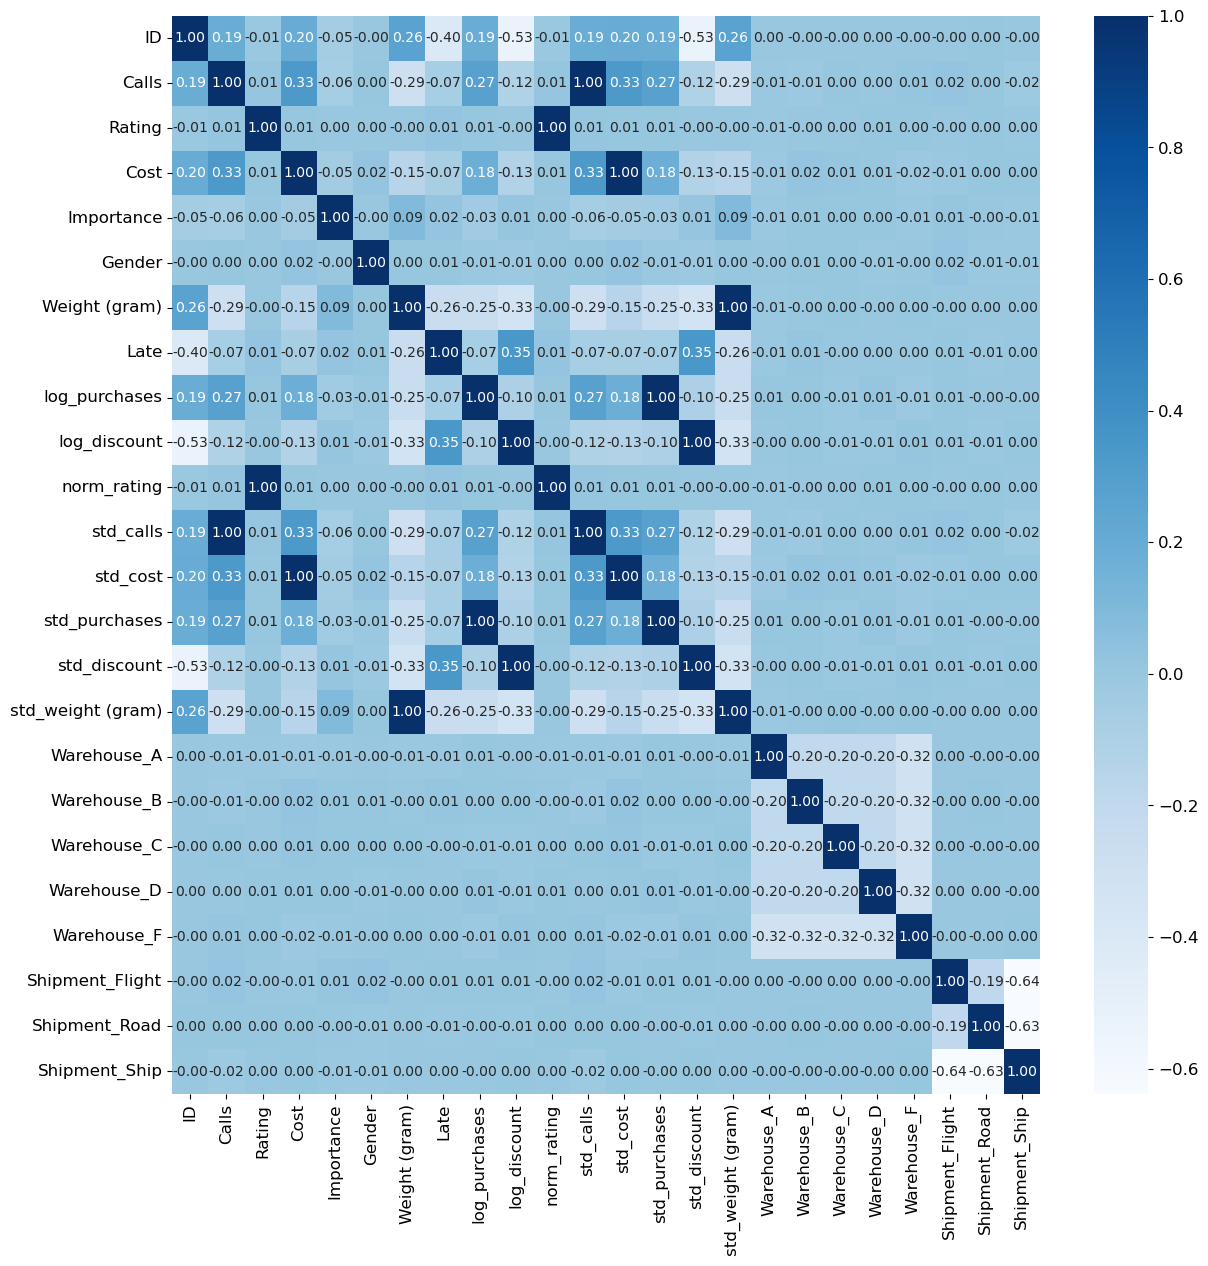

In [66]:
plt.figure(figsize=(14, 14))
sns.heatmap(df[numericals].corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show()

Analisis Heatmap plot: <br>
- Menghapus feature `ID` dikarenakan feature tersebut tidak memiliki arti penting untuk kegunaan proses modelling.
- Menghapus feature `Warehouse` dan `Shipment` karena sudah dilakukan feature encoding.
- Menghapus feature `Calls`, `Rating`, `Cost`, `Weight (gram)`, `log_purchases`, dan `log_discount` karena sudah di normalisasi / stdanrdisasi.
- Dari heatmap plot, tidak ada feature yang perlu dihapus karena tidak ada feature yang redundant dengan nilai korelasi antar feature > 0.7.

In [67]:
df.drop(columns=['ID', 'Warehouse', 'Shipment','Calls','Rating','Cost','Weight (gram)','log_purchases','log_discount'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10642 entries, 0 to 10998
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Importance         10642 non-null  int64  
 1   Gender             10642 non-null  int64  
 2   Late               10642 non-null  int64  
 3   norm_rating        10642 non-null  float64
 4   std_calls          10642 non-null  float64
 5   std_cost           10642 non-null  float64
 6   std_purchases      10642 non-null  float64
 7   std_discount       10642 non-null  float64
 8   std_weight (gram)  10642 non-null  float64
 9   Warehouse_A        10642 non-null  bool   
 10  Warehouse_B        10642 non-null  bool   
 11  Warehouse_C        10642 non-null  bool   
 12  Warehouse_D        10642 non-null  bool   
 13  Warehouse_F        10642 non-null  bool   
 14  Shipment_Flight    10642 non-null  bool   
 15  Shipment_Road      10642 non-null  bool   
 16  Shipment_Ship      10642 no

In [68]:
#ubah boolean menjadi int

boolean = ['Warehouse_A','Warehouse_B','Warehouse_C','Warehouse_D','Warehouse_F','Shipment_Flight','Shipment_Road','Shipment_Ship']

df[boolean] = df[boolean].astype(int)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10642 entries, 0 to 10998
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Importance         10642 non-null  int64  
 1   Gender             10642 non-null  int64  
 2   Late               10642 non-null  int64  
 3   norm_rating        10642 non-null  float64
 4   std_calls          10642 non-null  float64
 5   std_cost           10642 non-null  float64
 6   std_purchases      10642 non-null  float64
 7   std_discount       10642 non-null  float64
 8   std_weight (gram)  10642 non-null  float64
 9   Warehouse_A        10642 non-null  int32  
 10  Warehouse_B        10642 non-null  int32  
 11  Warehouse_C        10642 non-null  int32  
 12  Warehouse_D        10642 non-null  int32  
 13  Warehouse_F        10642 non-null  int32  
 14  Shipment_Flight    10642 non-null  int32  
 15  Shipment_Road      10642 non-null  int32  
 16  Shipment_Ship      10642 no

### **B. Feature Extraction**

In [70]:
df

,Importance,Gender,Late,norm_rating,std_calls,std_cost,std_purchases,std_discount,std_weight (gram),Warehouse_A,Warehouse_B,Warehouse_C,Warehouse_D,Warehouse_F,Shipment_Flight,Shipment_Road,Shipment_Ship
0,0,0,1,0.25,-0.057350,-0.698454,-0.223934,1.726343,-1.471860,0,0,0,1,0,1,0,0
1,0,1,1,1.00,-0.057350,0.112769,-1.366573,2.004155,-0.340605,0,0,0,0,1,1,0,0
2,0,1,1,0.25,-1.803627,-0.573650,0.586781,1.808746,-0.166190,1,0,0,0,0,1,0,0
3,1,1,1,0.50,-0.930489,-0.719254,0.586781,0.323204,-1.506011,0,1,0,0,0,1,0,0
4,1,0,1,0.25,-1.803627,-0.552850,-0.223934,1.768441,-0.708949,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10994,1,0,1,0.00,-0.057350,0.861590,1.215620,-1.857436,-1.285858,1,0,0,0,0,0,0,1
10995,1,0,0,0.00,-0.057350,0.445579,1.215620,-0.160568,-1.463322,0,1,0,0,0,0,0,1
10996,0,0,0,0.75,0.815788,0.653585,1.215620,-0.544560,-1.519427,0,0,1,0,0,0,0,1
10997,1,1,0,0.25,0.815788,0.258373,1.729420,-1.200998,-1.485886,0,0,0,0,1,0,0,1


Pengamatan: untuk feature extraction masih belum bisa dilakukan karena tidak ada feature yang bisa di ekstraksi

### **C. Feature Tambahan**

1. Waktu pengiriman - untuk mengetahui kapan paket dikirim
2. kota tujuan - untuk melihat lokasi atau jarak pengiriman
3. keadaan cuaca/musim - mengestimasi keterlambatan jika terjadi cuaca kurang bersahabat
4. ....
5. ....

## *APPENDIX*


### Handle Class Imbalance


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


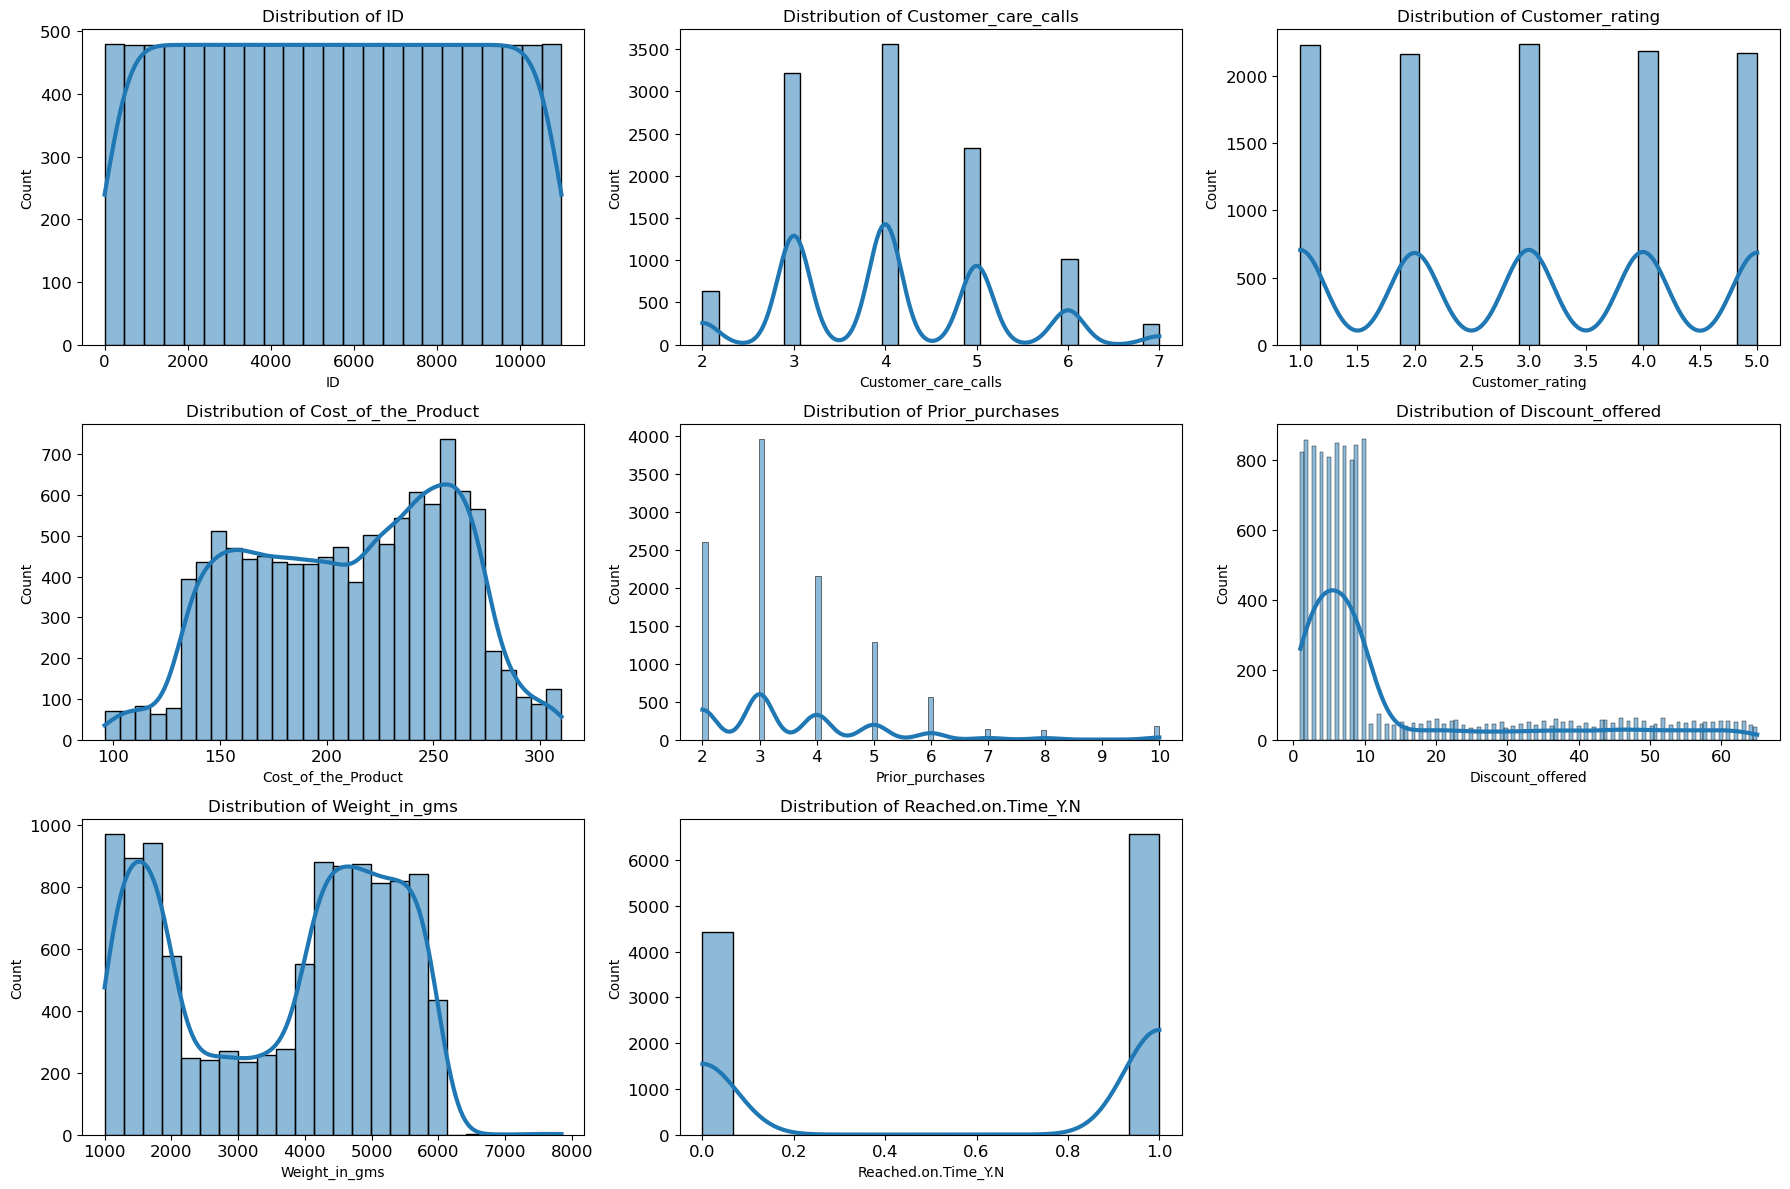

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numeric_distribution(df):
    # Pilih kolom numerik
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # Hitung jumlah subplot yang dibutuhkan
    num_plots = len(num_cols)
    num_rows = (num_plots - 1) // 3 + 1  # Menggunakan integer division untuk mendapatkan jumlah baris

    # Visualisasi distribusi fitur numerik
    plt.figure(figsize=(18, 12))
    for i in range(num_plots):
        plt.subplot(num_rows, 3, i+1)  # Menyesuaikan dengan jumlah kolom (3) dan jumlah baris
        sns.histplot(df[num_cols[i]], kde=True)
        plt.title(f'Distribution of {num_cols[i]}')
        plt.tight_layout()

    plt.show()

plot_numeric_distribution(df)


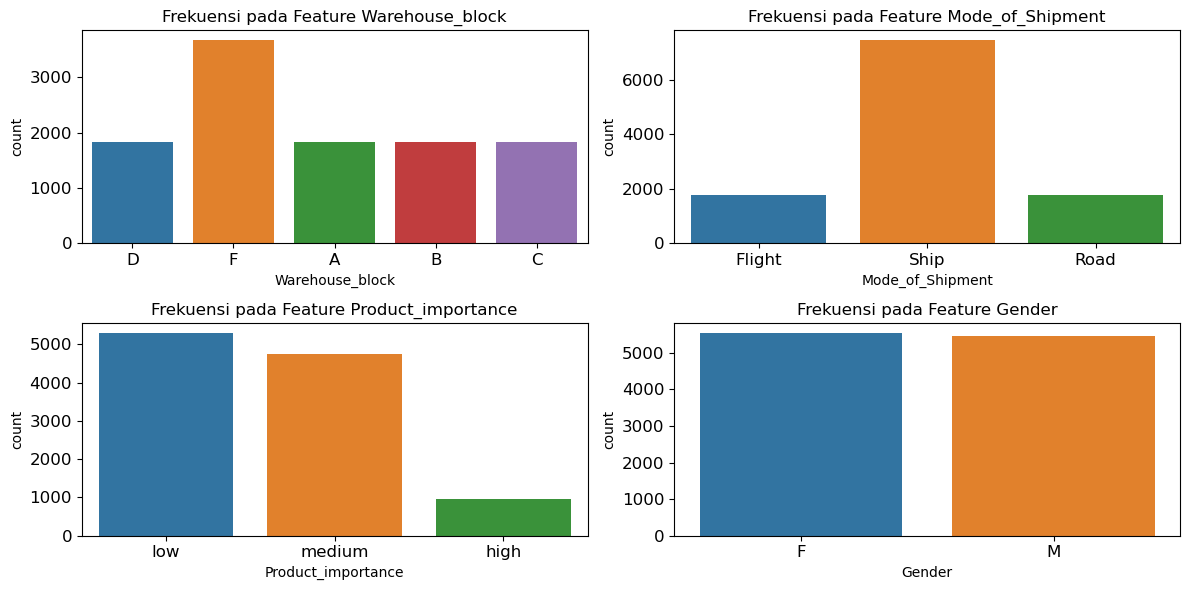

In [9]:
# Distriusi feature kategorikal
plt.figure(figsize = (12,6))
for i in range(0, len(cat)):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=df[cat[i]])
    plt.title(f'Frekuensi pada Feature {cat[i]}')
    plt.tight_layout()